In [47]:
#my alpha vantage api key to get data
#alpha vantage
key = 'DMBPCGJ6BBY2GAC3'
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators

from datetime import datetime,timedelta,date
import time

import seaborn as sns 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore', np.RankWarning)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor

from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
import keras

import sys

from xgboost import XGBRegressor


from statsmodels.graphics.tsaplots import plot_pacf

In [48]:
#See if GPU is available for Keras lstm layers 
import tensorflow as tf
from tensorflow import keras
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [49]:
ts = TimeSeries(key,output_format = 'pandas')
#daily open close average and volume of daily stock for microsoft 
day_stock, dat_meta = ts.get_daily(symbol = 'MSFT',outputsize = 'full')

In [50]:
#Analyse only the close prices for each day to avoid wild swings
close_price = day_stock.iloc[::-1,3]

In [51]:
# Regression to find if there is an overall trend week on week.

In [52]:
#Find the correlation between now and 5 days in the past 
X = close_price.shift(5).dropna()
y = close_price
y, X = y.align(X, join='inner')

X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [53]:
#Use linear regression to predict 5 days in the future and see the correlation between the two
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

Text(0.5, 0, 'Lag')

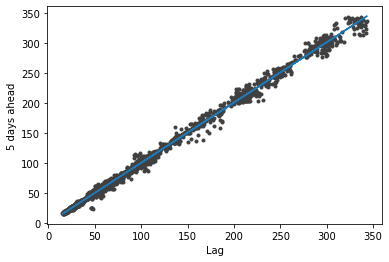

In [54]:
fig, ax = plt.subplots()
ax.plot(np.array(X), np.array(y), '.', color='0.25')
ax.plot(np.array(X), np.array(y_pred))
ax.set_ylabel('5 days ahead')
ax.set_xlabel('Lag')
# Strong correlation between lag 5 days ago and future stock price showing it can be used to predict future trends 

In [55]:
#Look at overall trends using moving averages 

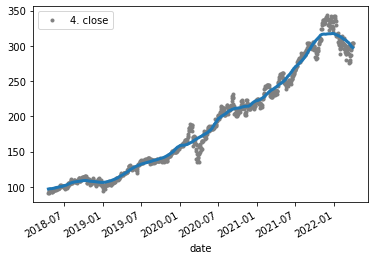

In [56]:
#use 1000 days to see the trend as not visable other wise 
ma = X[-1000:].rolling(
    window=100,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=50,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = X[-1000:].plot(style=".", color="0.5")
ma.plot(ax=ax, linewidth=3, legend=False);
#Can easily see and upwards trend over time from the previous 2 years 

In [57]:
#predict from moving average 10 days ahead 
X_avg = ma[0:980]
y = X[-990:-10]

model = LinearRegression(fit_intercept = False)
model.fit(X_avg, y)

y_pred = model.predict(X_avg)

In [58]:
y['pred'] = y_pred
y = y.reset_index()

C:\Users\Ben Grant\AppData\Local\Temp\ipykernel_9184\2048857351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['pred'] = y_pred


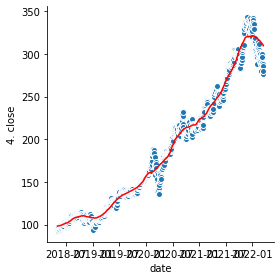

In [59]:
g = sns.FacetGrid(y, height = 4)
g = g.map(plt.scatter, "date", "4. close", edgecolor="w")
plt.plot(y['date'],y['pred'], color='r')
plt.show()

C:\Users\Ben Grant\AppData\Local\Temp\ipykernel_9184\2535072390.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_future['pred'] = y_future_pred


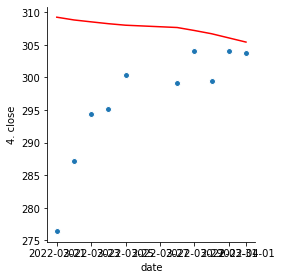

In [60]:
y_future_pred = model.predict(ma[980:990])
y_future = X[-10:]

y_future['pred'] = y_future_pred
y_future = y_future.reset_index()

#Show predicted future data, only 10 days ahead 
g = sns.FacetGrid(y_future, height = 4)
g = g.map(plt.scatter, "date", "4. close", edgecolor="w")
plt.plot(y_future['date'],y_future['pred'], color='r')
plt.show()

In [61]:
X['50_avg'] = X['4. close'].rolling(
    window=2,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=1,  # choose about half the window size
).mean()   

#Take away the moving average so trend does not affect the seasonality 
X['diff'] = X['4. close'] - X['50_avg']

X_per = np.array(X['diff']).reshape(len(X['diff']))
X

,4. close,50_avg,diff
date,,,
1999-11-08,92.37,92.370,0.000
1999-11-09,92.56,92.465,0.095
1999-11-10,92.00,92.280,-0.280
1999-11-11,91.75,91.875,-0.125
1999-11-12,91.56,91.655,-0.095
...,...,...,...
2022-03-28,299.16,299.795,-0.635
2022-03-29,304.06,301.610,2.450
2022-03-30,299.49,301.775,-2.285


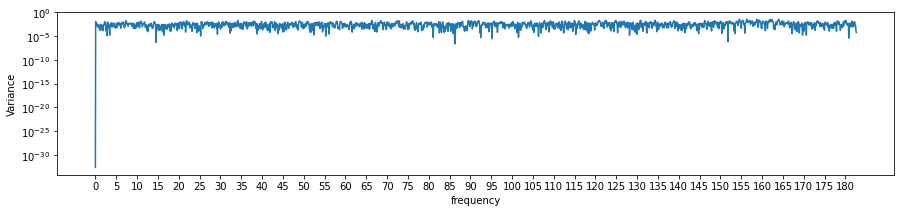

In [62]:
#Seasonality check find the period 
#Start by using a periodogram
from scipy import signal

#Use a year as total cycles 
fs = 365.25


f, Pxx_den = signal.periodogram(X_per, fs)

f
Pxx_den

plt.figure(figsize=(15,3)) 
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency')
plt.ylabel('Variance')
plt.xticks(np.arange(f.min(), f.max(), 5))
plt.show()

#No strong decreases in variance overall showing yearly trends will not help predict the movent of the market 

C:\Users\Ben Grant\anaconda3\envs\tensorflow\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


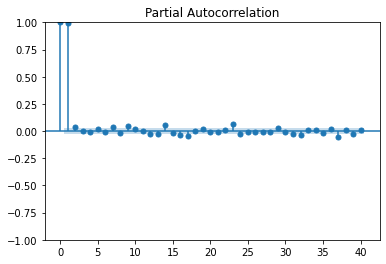

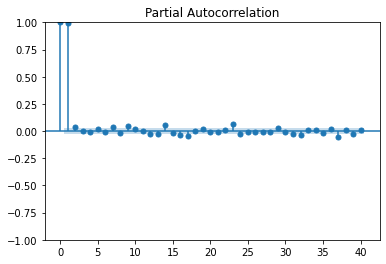

In [63]:
# using to see if there is any prediction for large scale divegences 
plot_pacf(X['4. close'], lags=40)

In [64]:
#Want to predict the next 3 weeks after so will have to be 20 days + correlation 
# use the highest correlated days outside of the 20 used  
X['lag_20'] = X['4. close'].shift(-20).fillna(X['4. close'][-1])
X['lag_22'] = X['4. close'].shift(-22).fillna(X['4. close'][-1])
X['lag_31'] = X['4. close'].shift(-31).fillna(X['4. close'][-1])

In [65]:
# break down into cycles trends and seasons
# no seasonal data so mad up of cycles and trends 

In [66]:
# look at the rolling standerd deviation as well as the market diverges a lot faster when recent variation increases 
X['10_std'] = X['4. close'].rolling(
    window=30,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=15,  
).std()  

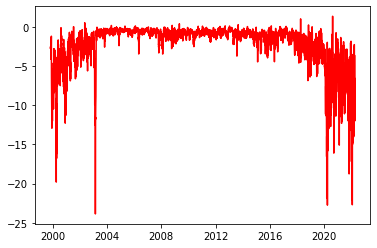

In [67]:
plt.plot(X.index,X['diff']-X['10_std'], color='r')
plt.show()

In [68]:
#Build the predictive model using XG boost and LSTM and compare the two for a 30 day predictions

In [69]:
#Split out the data in the train, test and predicted group
#Do the moving averages on the 20 day lagged data so there is no leakage 
No_pred_days = 20 

X['10_std_lag'] = X['lag_20'].rolling(
    window=10,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=5,  
).std()  

X['50_avg_lag'] = X['lag_20'].rolling(
    window=50,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=25,  # choose about half the window size
).sum()  

X_train = X[['lag_20','lag_22','lag_31','10_std_lag','50_avg_lag']][:-No_pred_days] 
y_train = X['4. close'][:-No_pred_days]

X_test  = X[['lag_20','lag_22','lag_31','10_std_lag','50_avg_lag']][-No_pred_days:] 
y_test = X['4. close'][-No_pred_days:]


In [70]:
#Create the pre scaled data for the model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop(['4. close','10_std','50_avg'],axis = 1))
y_scaled = scaler.fit_transform(np.array(X['4. close']).reshape(-1, 1))

#Create the testing data in steps for the model to use 
timestep = 20
#creating x and y train of data 
#y is the data at that point and x is a number of data points before data points before that
X_cond = []
y_cond = []
#the amount of dat input and to train the model over 
for i in range (0 ,len(X)-timestep): 
    # i - 10 as uses 10 points to predict the next one.
    X_cond.append(np.concatenate(X_scaled[i:i+timestep]))
    y_cond.append(y_scaled[i:i+timestep])
X_train,y_train = np.array(X_cond[:-20]),np.array(y_cond[:-20])
#reshape x so it can be input into the model 
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) 

#use the final 20 days of each for each to test the model 
X_test = X_cond[-1]
y_test = y_cond[-1]


In [71]:
#Train the first of two models, use a standerd xgboost decision tree and LSTM to deal with time series data 

In [72]:
#MultiOutputRegressor so XG boost can take multiple sections 
MOR = MultiOutputRegressor(XGBRegressor(random_state = 0)).fit(X_train.reshape(len(X_train), len(X_train[0])),y_train.reshape(len(y_train), len(y_train[0])))
    
XG_pred = MOR.predict(X_test.reshape(1,len(X_test)))

Text(0.5, 0, 'Time')

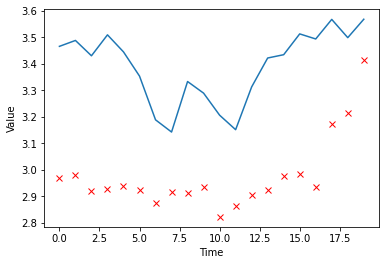

In [75]:
fig, ax = plt.subplots()
ax.plot(XG_pred.reshape(len(XG_pred[0]),1), 'x', color='r', label ="predicted data")
ax.plot(y_test, label= "train data")
#plt.legend(loc="best")
ax.set_ylabel('Value')
ax.set_xlabel('Time')

In [76]:
#Not a very good prediction as XG doenst take into account trends of the data 
#Next LSTM will be tried 

In [77]:
model = Sequential()
#100 lstm units in each section along with input of shape 
model.add(LSTM(units=100, return_sequences = True,
               input_shape=(X_train.shape[1],X_train.shape[2])))
#Dropout to avoid over fitting on most recent data
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=len(y_test), return_sequences = False))
model.add(Dropout(0.2))

#final unit for y predictions 
model.add(Dense(units =y_train.shape[1]))
#use adam optimizer for optimisation algorithm and mse as loss function 
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),loss=keras.losses.MeanSquaredError())
#batch size of 32 tested each time 
model.fit(X_train, y_train, epochs = 10, batch_size = 5, verbose=2)

Epoch 1/10
1120/1120 - 33s - loss: 0.1127 - 33s/epoch - 30ms/step
Epoch 2/10
1120/1120 - 29s - loss: 0.0621 - 29s/epoch - 26ms/step
Epoch 3/10
1120/1120 - 28s - loss: 0.0470 - 28s/epoch - 25ms/step
Epoch 4/10
1120/1120 - 28s - loss: 0.0381 - 28s/epoch - 25ms/step
Epoch 5/10
1120/1120 - 28s - loss: 0.0371 - 28s/epoch - 25ms/step
Epoch 6/10
1120/1120 - 28s - loss: 0.0345 - 28s/epoch - 25ms/step
Epoch 7/10
1120/1120 - 28s - loss: 0.0314 - 28s/epoch - 25ms/step
Epoch 8/10
1120/1120 - 28s - loss: 0.0323 - 28s/epoch - 25ms/step
Epoch 9/10
1120/1120 - 28s - loss: 0.0308 - 28s/epoch - 25ms/step
Epoch 10/10
1120/1120 - 28s - loss: 0.0281 - 28s/epoch - 25ms/step


Text(0.5, 0, 'Time')

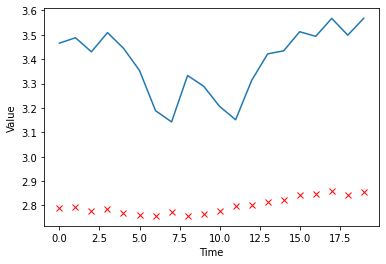

In [78]:
fig, ax = plt.subplots()
ax.plot(model.predict(X_test.reshape(1, 120, 1)).reshape(len(XG_pred[0]),1), 'x', color='r', label ="predicted data")
ax.plot(y_test, label= "train data")
#plt.legend(loc="best")
ax.set_ylabel('Value')
ax.set_xlabel('Time')

In [ ]:
# Most likely follows the moving average as this is closest on average to each data point over time so the larger deviation's
# can lead to incorrect predictons as shown 